In [1]:
import mne
import numpy as np
from matplotlib import pyplot as plt
import math
from scipy import stats, signal
import itertools
import pandas as pd
from datetime import datetime

/Users/rotemfalach/projects/mne-python/lib/python3.7/site-packages/pandas/compat/__init__.py:97: UserWarning: Could not import the lzma module. Your installed Python is incomplete. Attempting to use lzma compression will result in a RuntimeError.
  warnings.warn(msg)


In [2]:
# consts
threshold_env = 8  
threshold_amp = 5  
threshold_grad = 5
use_env = True
use_amp = True
use_grad = True
block_size_sec = 10  # filter and find peaks at blocks of X seconds - based on Andrillon et al

# the bandpass range is based on Andrillon et al
low_pass = 50
high_pass = 150

# general constants
min_distance = 200  # minimal distance for 'different' spikes - in miliseconds
min_spike_length_sec = 0.004  # a spike is detected if there are points for 5 ms passing the threshold, based on Andrillon et al


In [23]:
def get_markers(data, index_above_threshold, thresh_type):
    max_markers_index = []
    max_marker_value = []

    # find max markers
#     counter = 1
    curr_spike = []
    curr_spike_data = [thresh_type, index_above_threshold[0]]
    curr_spike.append(index_above_threshold[0])
    for j in range(len(index_above_threshold)):
        # check that the next index is the same spike
        if j + 1 < len(index_above_threshold) and index_above_threshold[j + 1] - index_above_threshold[j] == 1:
            curr_spike.append(index_above_threshold[j + 1])
        # the current spike finished
        else:
            # check min spike length
            if sampling_rate * min_spike_length_sec <= len(curr_spike):
                # check if the peak is positive or negative and append it's value
                max_value = data[curr_spike[0]: curr_spike[-1] + 1].max()
                min_value = data[curr_spike[0]: curr_spike[-1] + 1].min()
                value = max_value if abs(max_value) > abs(min_value) else min_value
                print(value)
                print(curr_spike)
                index = np.intersect1d(np.where(data == value)[0], curr_spike)[0]
                max_marker_value.append(value)
                max_markers_index.append(index)
                curr_spike = []
                curr_spike_data.extend((index_above_threshold[j], index, value))
                spikes_list.append(curr_spike_data)
            
            if j + 1 < len(index_above_threshold):
                curr_spike_data = [thresh_type, index_above_threshold[j + 1]]

    return np.array(max_markers_index), np.array(max_marker_value)

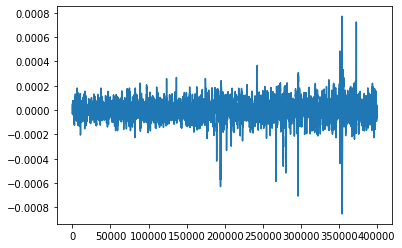

In [24]:
common_spikes_index = []
# format: [spike_id, threshold_type, first_index, last_index, max_index, max_amp, duration(calc once for all after convert to df), sleep_stage?]
spikes_list = []
id = '402_RAH1-RAH2_bi'
# edf = '/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/402_for_tag.edf'
mne.set_log_level(False)
edf = '/Users/rotemfalach/Documents/University/lab/EDFs_forRotem/402_for_tag.edf'
raw = mne.io.read_raw_edf(edf)
sampling_rate = int(raw.info['sfreq'])
raw.pick_channels(['RAH1-RAH2'])
raw.crop(tmin=0, tmax=200)

data = raw.get_data()[0]
plt.plot(data)

In [25]:
points_in_block = block_size_sec * sampling_rate
number_of_blocks = math.floor(len(data) / points_in_block)
max_markers_index_amp, max_markers_index_grad, max_markers_index_env, all_common_index, all_common_value = [], [], [], [], []

for i in range(number_of_blocks):
    curr_block = data[i * points_in_block: (i + 1) * points_in_block]

    # check amplitude threshold
    if use_amp or use_amp_env or use_amp_grad:
        z_score_amp = stats.zscore(curr_block)
        points_above_thresh_amp = z_score_amp[z_score_amp > threshold_amp]
        # get indexes from z_score values and add offset of the current block
        if len(points_above_thresh_amp) > 0:
            index_above_threshold_amp = (z_score_amp > threshold_amp).nonzero()[0] + i * points_in_block
            max_markers_index_amp, max_marker_value_amp = get_markers(data, index_above_threshold_amp, 'amp')
            print(max_markers_index_amp)

    # check gradient threshold
    if use_grad or use_amp_grad:
        gradient_diff = np.diff(curr_block)
        z_score_grad = stats.zscore(np.insert(gradient_diff, 0, 0))
        points_above_thresh_grad = z_score_grad[z_score_grad > threshold_grad]
        if len(points_above_thresh_grad) > 0:
            index_above_threshold_grad = (z_score_grad > threshold_grad).nonzero()[0] + i * points_in_block
            max_markers_index_grad, max_marker_value_grad = get_markers(data, index_above_threshold_grad, 'grad')

    # check envelope threshold
    if use_env or use_amp_env:
        filtered_block = mne.filter.filter_data(curr_block, sampling_rate, low_pass, high_pass)
        env_block = abs(signal.hilbert(filtered_block))
        z_score_env = stats.zscore(env_block)
        points_above_thresh_env = z_score_env[z_score_env > threshold_env]
        if len(points_above_thresh_env) > 0:
            index_above_threshold_env = (z_score_env > threshold_env).nonzero()[0] + i * points_in_block
            max_markers_index_env, max_marker_value_env = get_markers(data, index_above_threshold_env, 'env')


-0.00012977798123140266
[16191, 16192, 16193, 16194, 16195, 16196, 16197, 16198, 16199, 16200, 16201, 16202, 16203, 16204, 16205, 16206, 16207, 16208, 16209, 16210, 16211]
-0.0001223010605020214
[56805, 56806, 56807, 56808, 56809, 56810, 56811, 56812, 56813, 56814, 56815, 56816, 56817, 56818, 56819, 56820, 56821, 56822, 56823, 56824, 56825, 56826, 56827, 56828]
-0.0002118715190356294
[82371, 82372, 82373, 82374, 82375, 82376, 82377, 82378, 82379, 82380, 82381, 82382, 82383, 82384, 82385, 82386, 82387, 82388, 82389, 82390, 82391, 82392, 82393, 82394, 82395, 82396, 82397, 82398]
-5.1041428244449106e-05
[82480, 82481, 82482, 82483, 82484, 82485, 82486, 82487]
0.0002559700923170829
[123744, 123745, 123746, 123747, 123748, 123749, 123750, 123751, 123752, 123753, 123754, 123755, 123756, 123757, 123758, 123759, 123760, 123761, 123762, 123763, 123764, 123765, 123766, 123767, 123768]
0.0002584115358205544
[123744, 123745, 123746, 123747, 123748, 123749, 123750, 123751, 123752, 123753, 123754, 1

IndexError: index 0 is out of bounds for axis 0 with size 0

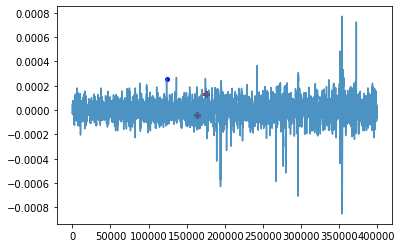

In [6]:
plt.plot(data, alpha=0.8)
plt.scatter(max_markers_index_amp, data[max_markers_index_amp] if len(max_markers_index_amp) > 0 else [], marker='X', color='fuchsia')
plt.scatter(max_markers_index_grad, data[max_markers_index_grad] if len(max_markers_index_grad) > 0 else [], marker='P', color='red')
plt.scatter(max_markers_index_env, data[max_markers_index_env] if len(max_markers_index_env) > 0 else [], marker='o', color='blue', s=15)

In [7]:
max_markers_index_amp

[]

In [14]:
np.where(data == -0.00021934843976501064)

(array([177191, 194496, 354935, 354936]),)

In [18]:
x = [1, 2, 3, 4]
x[-1]

4